In [1]:
import pandas as pd
import numpy as np 

In [2]:
import os 
path_dir = './Final_data/one_week/'
file_list = os.listdir(path_dir)

In [3]:
del file_list[26] 
len(file_list) 

187

In [4]:
df_list = []
cust_ip_list = [] 

for i in file_list:
    tmp_df = pd.read_parquet(path_dir+i, engine='pyarrow')
    tmp_df['stamp_inserted'] = pd.to_datetime(tmp_df['stamp_inserted'], format='%Y%m%d%H%M%S')
    tmp_df.event.fillna(0, inplace=True)
    df_list.append(tmp_df)
    c_ip = tmp_df.iloc[0].cust_ip_no
    cust_ip_list.append(c_ip) 

In [5]:
# 디도스 + 전체 시간이 있는 데이터 
e_data = []
for n, df in enumerate(df_list):
   # if len(df) >= 10080 or 1 in df.event.values :
    if 1 in df.event.values:
        print(n) 
        e_data.append(df) 

2
5
15
52
92
113
150
160
169


In [6]:
for n, df in enumerate(e_data):
    e_data[n] = df.drop_duplicates(['stamp_inserted'], keep='first')

In [7]:
for df in e_data:
    df.reset_index(drop=True, inplace=True) 

In [8]:
from tqdm import tqdm
seq_time = 10
iv = ['bytes', 'pkts',
       'sip_entropy', 'dip_entropy', 'spt_entropy', 'dpt_entropy',
       'proto_entropy', 'tcp_flags_entropy', 'icmp_ratio', 'tcp_ratio',
       'udp_ratio', 'domestic_ratio', 'in_ratio', 'inner_ratio']
features = len(iv)

normal_X = []
normal_y = []
abnormal_X = []
abnormal_y = []


for j in tqdm(range(len(e_data))):
    normal_data = pd.DataFrame(columns=iv)
    normal_label = []
    abnormal_data = pd.DataFrame(columns=iv)
    abnormal_label = []
    for i in range(len(e_data[j]) - seq_time):        
        input_x = e_data[j].iloc[i:i+seq_time,3:-4]
        label = e_data[j].iloc[i+seq_time, -4]
        ip_NO = e_data[j].iloc[i+seq_time, 2] 
        
        if label == 0:
            normal_data = pd.concat([normal_data, input_x], axis=0)
            ip_label_set = (ip_NO, label)            
            normal_label.append(ip_label_set)
            
        else :
            abnormal_data = pd.concat([abnormal_data, input_x], axis=0)
            ip_label_set = (ip_NO, label)
            abnormal_label.append(ip_label_set)
            
    normal_X.append(normal_data)
    normal_y.append(normal_label)
    if len(abnormal_data) != 0:
        abnormal_X.append(abnormal_data)
        abnormal_y.append(abnormal_label)   
        

100%|██████████| 9/9 [06:02<00:00, 40.31s/it]


In [9]:
# 정규화
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
#scaler = MinMaxScaler(feature_range=(-1,1))
scaler = MinMaxScaler(feature_range=(0,1))

X_normal = pd.DataFrame(columns=iv)
for i in normal_X:
    tmp_input = pd.DataFrame(scaler.fit_transform(i.values), columns=iv)
    X_normal = pd.concat([X_normal, tmp_input], axis=0)

y_normal = []
for i in normal_y:
    y_normal.extend(i)

    
    
X_abnormal = pd.DataFrame(columns=iv)
for i in abnormal_X:
        tmp_input = pd.DataFrame(scaler.fit_transform(i.values), columns=iv)
        X_abnormal = pd.concat([X_abnormal, tmp_input], axis=0)

y_abnormal = []
for i in abnormal_y:
    y_abnormal.extend(i)
        

In [10]:
X_normal = X_normal.values.reshape(-1, 10, 14)
X_abnormal = X_abnormal.values.reshape(-1, 10, 14)  

In [11]:
from sklearn.model_selection import train_test_split
train_X_ae, test_X_ae, train_y_ae, test_y_ae = train_test_split(X_normal, y_normal, test_size=0.1, shuffle=True)

print(train_X_ae.shape) 
print(test_X_ae.shape)  

(81299, 10, 14)
(9034, 10, 14)


In [12]:
# test set에 일부 정상 값을 함께 넣어줌
test_X_ae= np.concatenate((test_X_ae, X_abnormal), axis=0)
test_y_ae = np.concatenate((test_y_ae, y_abnormal), axis=0)

print(train_X_ae.shape)
print(test_X_ae.shape) 
print(test_y_ae.shape) 

(81299, 10, 14)
(9213, 10, 14)
(9213, 2)


In [13]:
test_y_df = pd.DataFrame(test_y_ae, columns=['ip','label'])
test_y_df.head()

ip  label
0   8879.0    0.0
1  16481.0    0.0
2  14011.0    0.0
3   8923.0    0.0
4   8939.0    0.0

# 1. Bi-LSTM VAE 

In [16]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector, Bidirectional, TimeDistributed
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives


In [171]:
adam = Adam(lr=0.0001)
input_shape = (seq_time, features)
hidden_dim = 14
hidden_dim1 = 8
latent_dim = 4


K.clear_session()  
x = Input(shape=(seq_time, features))
xx = Flatten()(x)

#Encoder
h = Bidirectional(LSTM(hidden_dim, dropout=0.2, activation='relu', return_sequences=True))(x)
h1 = LSTM(hidden_dim1, activation='relu', return_sequences=False)(h)
z_mean = Dense(latent_dim)(h1)
z_sigma = Dense(latent_dim)(h1)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                stddev = 1.)
    return z_mean + K.exp(z_log_var/2) *epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_sigma])

#Decoder
d1 = RepeatVector(seq_time)(z)
d2 = LSTM(hidden_dim1, activation='relu', return_sequences=True)(d1)
d3 = LSTM(hidden_dim, activation='relu', return_sequences=True)(d2)
x_hat = TimeDistributed(Dense(features))(d3)
x_hh = Flatten()(x_hat)

lstm_vae = Model(x, x_hat)
#lstm_vae.compile(optimizer=adam, loss='mse')  
#lstm_vae.summary() 

encoder = Model(x, z) 
#encoder.summary()  

In [172]:
lstm_vae = Model(x, x_hat)

xent_loss = 140 * objectives.mse(xx, x_hh) 
kl_loss = -0.5 * K.sum(1+z_sigma - K.square(z_mean) - K.exp(z_sigma), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss) 

lstm_vae.add_loss(vae_loss) 
lstm_vae.compile(optimizer=adam)  
lstm_vae.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 14)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 10, 28)       3248        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 8)            1184        bidirectional[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 4)            36          lstm_1[0][0]                     
_______________________________________________________________________________________

In [184]:
hist = lstm_vae.fit(train_X_ae, train_X_ae, epochs=50, validation_split=0.1, batch_size=64, shuffle=True,
                  verbose=2) 

Epoch 1/50
1144/1144 - 12s - loss: 6.1103 - val_loss: 6.0720
Epoch 2/50
1144/1144 - 13s - loss: 6.0990 - val_loss: 6.0507
Epoch 3/50
1144/1144 - 13s - loss: 6.0967 - val_loss: 6.0417
Epoch 4/50
1144/1144 - 13s - loss: 6.0664 - val_loss: 6.0398
Epoch 5/50
1144/1144 - 13s - loss: 6.0591 - val_loss: 6.0513
Epoch 6/50
1144/1144 - 13s - loss: 6.0654 - val_loss: 6.0151
Epoch 7/50
1144/1144 - 13s - loss: 6.0472 - val_loss: 5.9899
Epoch 8/50
1144/1144 - 13s - loss: 6.0348 - val_loss: 5.9390
Epoch 9/50
1144/1144 - 13s - loss: 6.0279 - val_loss: 5.9974
Epoch 10/50
1144/1144 - 13s - loss: 6.0253 - val_loss: 6.0021
Epoch 11/50
1144/1144 - 13s - loss: 6.0090 - val_loss: 5.9570
Epoch 12/50
1144/1144 - 13s - loss: 6.0045 - val_loss: 5.9605
Epoch 13/50
1144/1144 - 13s - loss: 6.0053 - val_loss: 5.9826
Epoch 14/50
1144/1144 - 13s - loss: 5.9957 - val_loss: 5.9231
Epoch 15/50
1144/1144 - 13s - loss: 5.9753 - val_loss: 5.9616
Epoch 16/50
1144/1144 - 13s - loss: 5.9725 - val_loss: 5.9533
Epoch 17/50
1144/

In [174]:
from plotly.offline import plot, iplot 
import plotly.graph_objects as go

loss = hist.history['loss'] 
val_loss = hist.history['val_loss'] 

fig = go.Figure()
fig.add_trace(go.Scatter(y=loss, mode='lines', name='loss'))
fig.add_trace(go.Scatter(y=val_loss, mode='lines', name='val_loss'))
fig.update_layout(height=400, width=600, title='loss of LSTM VAE')
fig.show() 

In [185]:
test_X_ae = test_X_ae.reshape(-1, 10, 14) 
pred_x = lstm_vae.predict(test_X_ae).reshape(test_X_ae.shape[0], -1)
test_X_ae = test_X_ae.reshape(test_X_ae.shape[0], -1)
mse = np.mean(np.power(test_X_ae - pred_x, 2), axis=1) 
test_y_df['reconstruction_error'] = mse
test_y_df

ip  label  reconstruction_error        z1        z2        z3
0      8939.0    0.0              0.001819 -0.467407 -0.102343 -0.872697
1     11617.0    0.0              0.002482 -0.218493 -1.662051 -0.985654
2      8879.0    0.0              0.002788 -0.018762 -0.475059 -2.315606
3      8923.0    0.0              0.004803 -0.013112  1.350612  0.741024
4     11617.0    0.0              0.003811 -2.049803 -3.173020 -0.912761
...       ...    ...                   ...       ...       ...       ...
9208   8205.0    1.0              0.242037 -0.051455 -0.817974  1.133438
9209   8205.0    1.0              0.396665  0.135248 -0.696287  0.267884
9210   8205.0    1.0              0.417498  0.840389 -0.763098  1.017506
9211   8205.0    1.0              0.445653  1.232660 -0.236536  0.859466
9212   8205.0    1.0              0.472547  1.670346 -0.790561  0.142578

[9213 rows x 6 columns]

In [186]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=test_y_df['reconstruction_error'], mode='lines', name='error'))
fig.add_trace(go.Scatter(y=test_y_df['label'], mode='lines', name='label'))
fig.update_layout(height=400, width=800, title='Rescaling Result of Bi-LSTM AE')
fig.update_xaxes(rangeslider_visible=True)
fig.show() 

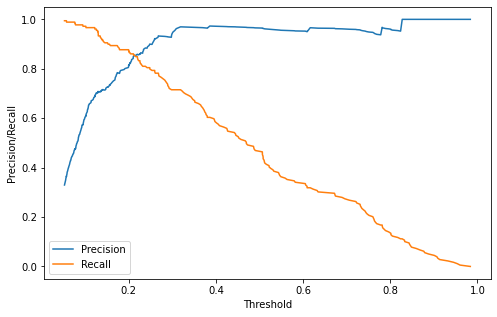

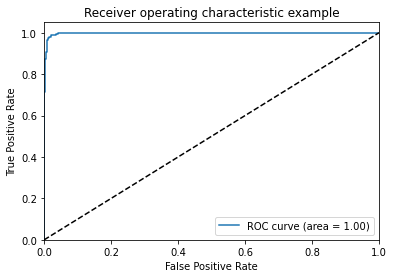

In [187]:
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
import matplotlib.pyplot as plt
precision_rt, recall_rt, threshold_rt = precision_recall_curve(test_y_df['label'], test_y_df['reconstruction_error'])
fpr, tpr, thresholds = metrics.roc_curve(test_y_df['label'], test_y_df['reconstruction_error'])
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall') 
plt.legend() 
plt.show() 

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show() 

In [188]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed) 

precision:  0.8547486033519553 , recall:  0.8547486033519553
threshold:  0.21609886676890794


In [189]:
from sklearn.metrics import classification_report, confusion_matrix

pred_y = [ 1 if e> threshold_fixed else 0 for e in test_y_df['reconstruction_error'].values]
print(classification_report(test_y_df.label, pred_y))  
print(confusion_matrix(test_y_df.label, pred_y)) 


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9034
         1.0       0.85      0.85      0.85       179

    accuracy                           0.99      9213
   macro avg       0.93      0.92      0.92      9213
weighted avg       0.99      0.99      0.99      9213

[[9008   26]
 [  27  152]]


In [190]:
test_X_ae = test_X_ae.reshape(-1, 10, 14)
X_test_encoded = encoder.predict(test_X_ae, batch_size=64)
test_y_df['z1'] = X_test_encoded[:,0]
test_y_df['z2'] = X_test_encoded[:,1]
test_y_df['z3'] = X_test_encoded[:,2]
test_y_df.head()

ip  label  reconstruction_error        z1        z2        z3
0   8939.0    0.0              0.001819 -0.076712  0.099871 -1.131272
1  11617.0    0.0              0.002482 -0.201120 -1.806524 -0.932717
2   8879.0    0.0              0.002788 -0.393639 -0.723699 -1.531974
3   8923.0    0.0              0.004803  0.030385  1.354692  0.442446
4  11617.0    0.0              0.003811  0.774426 -2.645320  0.027783

In [191]:
import plotly.express as px
fig = px.scatter(test_y_df, x='z1', y='z2',color='ip',
                 symbol='label', size_max=0.01, opacity=0.6,
                width=500, height=450)
fig.show()

In [192]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=test_y_df[test_y_df['label']==0].z1, y=test_y_df[test_y_df['label']==0].z2, 
                           z=test_y_df[test_y_df['label']==0].z3, name='normal', mode='markers', 
                          marker=dict(size=2, color=test_y_df[test_y_df['label']==0].ip, opacity=0.7)
                          ,text=test_y_df[test_y_df['label']==0].ip))

fig.add_trace(go.Scatter3d(x=test_y_df[test_y_df['label']==1].z1, y=test_y_df[test_y_df['label']==1].z2,
             z=test_y_df[test_y_df['label']==1].z3, name='ddos', mode='markers',
             marker=dict(size=4, color=test_y_df[test_y_df['label']==1].ip, opacity=0.7, symbol='square')
                          ,text=test_y_df[test_y_df['label']==1].ip))


fig.update_layout(title='Latent space of each IP')
fig.show() 

In [195]:
test1 = test_y_df[test_y_df.ip==16481] 
test1.head()

ip  label  reconstruction_error        z1        z2        z3
6   16481.0    0.0              0.006221 -0.829210  1.145221  1.053927
7   16481.0    0.0              0.019280  0.229034  1.173967  0.153249
13  16481.0    0.0              0.009455 -0.358367  0.855682  0.656251
14  16481.0    0.0              0.004384 -1.229054  1.033911  0.354568
19  16481.0    0.0              0.012248  0.197454  1.131237 -0.059824

In [196]:
test1 = test_y_df[test_y_df.ip==16481] 

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=test1[test1['label']==0].z1, y=test1[test1['label']==0].z2, 
                           z=test1[test1['label']==0].z3, name='normal', mode='markers', 
                          marker=dict(size=2, color=test1[test1['label']==0].reconstruction_error, opacity=0.7)
                          ,text=test1[test1['label']==0].reconstruction_error))

fig.add_trace(go.Scatter3d(x=test1[test1['label']==1].z1, y=test1[test1['label']==1].z2,
             z=test1[test1['label']==1].z3, name='ddos', mode='markers',
             marker=dict(size=4, color=test1[test1['label']==1].reconstruction_error, opacity=0.7, symbol='square')
                          ,text=test1[test1['label']==1].reconstruction_error))


fig.update_layout(title='Latent space of each IP')
fig.show() 

In [99]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from plotly.offline import plot
plot(fig, filename='latent_space_kld.html', auto_open=False) 

'latent_space_kld.html'

# 3. CVAE

In [18]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm 
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Dropout, BatchNormalization
from keras.layers import Conv1D, Conv1DTranspose
from keras.models import Model, Sequential 
from keras import backend as K
from keras import objectives, metrics, layers

In [19]:
input_dim = features
timesteps = seq_time
batch_size = 64
hidden_dim = 14
hidden_dim1 = 7
latent_dim = 4
epsilon_std = 1.0
kernel_s = 6
adam = Adam(lr=0.0001)

In [50]:
x = Input(shape=(10, 14))
xx = Flatten()(x)

Enc = Sequential([x,
    layers.Conv1D(filters=hidden_dim, kernel_size=kernel_s, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(filters=hidden_dim1, kernel_size=kernel_s, padding='same', strides=1, activation='relu'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Flatten()]) 

z_mean = Dense(latent_dim)(Enc(x))  #(4,)
z_log_var = Dense(latent_dim)(Enc(x)) #(4,)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                stddev = 1.)
    return z_mean + K.exp(z_log_var/2) *epsilon


z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

re_z = RepeatVector(seq_time)(z) 
Dec = Sequential([
    Conv1DTranspose(filters=latent_dim, kernel_size=kernel_s, padding='same', strides=1, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1DTranspose(filters=hidden_dim1, kernel_size=kernel_s, padding='same', strides=1, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1DTranspose(filters=hidden_dim, kernel_size=kernel_s, padding='same', strides=1, activation='relu'),
    #layers.BatchNormalization(),
    layers.Conv1DTranspose(filters=14, kernel_size=kernel_s, padding='same')])
    #layers.BatchNormalization()])


x_hat = Dec(re_z)
x_hh = Flatten()(x_hat) 

cvae = Model(x, x_hat) 
cvae.compile(optimizer=adam, loss='mse')
cvae.summary() 
cvae_encoder = Model(x, z)
#cvae_decoder = Model(re_z, x_hat)

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 10, 14)]     0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 70)           1869        input_6[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 4)            284         sequential_7[0][0]               
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 4)            284         sequential_7[1][0]   

In [51]:
cvae = Model(x, x_hat)

xent_loss = 140 * objectives.mse(xx, x_hh) 
kl_loss = -0.5 * K.sum(1+z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
vae_loss = K.mean(xent_loss + kl_loss) 

cvae.add_loss(vae_loss) 
cvae.compile(optimizer=adam)  
cvae.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 10, 14)]     0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 70)           1869        input_6[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 4)            284         sequential_7[0][0]               
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 4)            284         sequential_7[1][0]   

In [53]:
hist = cvae.fit(train_X_ae, train_X_ae, shuffle=True, epochs=50, batch_size=64, validation_split=0.1,
       verbose=2) 

Epoch 1/50
1144/1144 - 7s - loss: 3.5079 - val_loss: 3.4271
Epoch 2/50
1144/1144 - 7s - loss: 3.4969 - val_loss: 3.4257
Epoch 3/50
1144/1144 - 7s - loss: 3.4922 - val_loss: 3.4329
Epoch 4/50
1144/1144 - 7s - loss: 3.4943 - val_loss: 3.4116
Epoch 5/50
1144/1144 - 6s - loss: 3.4941 - val_loss: 3.5059
Epoch 6/50
1144/1144 - 7s - loss: 3.4856 - val_loss: 3.4156
Epoch 7/50
1144/1144 - 7s - loss: 3.4874 - val_loss: 3.4053
Epoch 8/50
1144/1144 - 6s - loss: 3.4843 - val_loss: 3.4199
Epoch 9/50
1144/1144 - 7s - loss: 3.4867 - val_loss: 3.4174
Epoch 10/50
1144/1144 - 7s - loss: 3.4793 - val_loss: 3.4174
Epoch 11/50
1144/1144 - 8s - loss: 3.4826 - val_loss: 3.4162
Epoch 12/50
1144/1144 - 7s - loss: 3.4772 - val_loss: 3.4241
Epoch 13/50
1144/1144 - 7s - loss: 3.4690 - val_loss: 3.4144
Epoch 14/50
1144/1144 - 8s - loss: 3.4691 - val_loss: 3.4025
Epoch 15/50
1144/1144 - 8s - loss: 3.4730 - val_loss: 3.3806
Epoch 16/50
1144/1144 - 8s - loss: 3.4652 - val_loss: 3.3981
Epoch 17/50
1144/1144 - 7s - loss

In [54]:
import plotly.graph_objects as go
loss = hist.history['loss'] 
val_loss = hist.history['val_loss'] 

fig = go.Figure()
fig.add_trace(go.Scatter(y=loss, mode='lines', name='loss'))
fig.add_trace(go.Scatter(y=val_loss, mode='lines', name='val_loss'))
fig.update_layout(height=400, width=600, title='loss of CVAE')
fig.show() 

In [55]:
test_X_ae = test_X_ae.reshape(-1, 10, 14) 
pred_x = cvae.predict(test_X_ae).reshape(test_X_ae.shape[0], -1)
test_X_ae = test_X_ae.reshape(test_X_ae.shape[0], -1)
mse = np.mean(np.power(test_X_ae - pred_x, 2), axis=1) 
test_y_df['reconstruction_error'] = mse
test_y_df

ip  label  reconstruction_error
0      8879.0    0.0              0.001349
1     16481.0    0.0              0.003913
2     14011.0    0.0              0.004126
3      8923.0    0.0              0.004422
4      8939.0    0.0              0.008155
...       ...    ...                   ...
9208   8205.0    1.0              0.066976
9209   8205.0    1.0              0.099419
9210   8205.0    1.0              0.115590
9211   8205.0    1.0              0.114857
9212   8205.0    1.0              0.105826

[9213 rows x 3 columns]

In [56]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=test_y_df['reconstruction_error'], mode='lines', name='error'))
fig.add_trace(go.Scatter(y=test_y_df['label'], mode='lines', name='label'))
fig.update_layout(height=400, width=800, title='Rescaling Result of CVAE')
fig.update_xaxes(rangeslider_visible=True)
fig.show() 

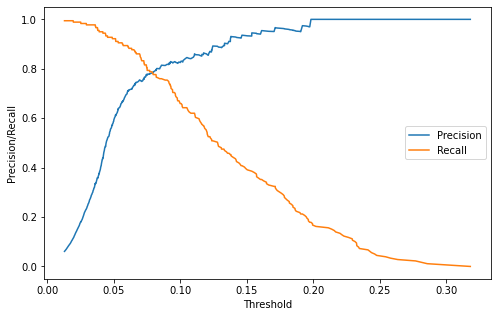

In [57]:
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
import matplotlib.pyplot as plt

precision_rt, recall_rt, threshold_rt = precision_recall_curve(test_y_df['label'], test_y_df['reconstruction_error'])
#fpr, tpr, thresholds = metrics.roc_curve(test_y_df['label'], test_y_df['reconstruction_error'])
#roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend() 
plt.show()


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed) 

# cf metrics
pred_y = [ 1 if e> threshold_fixed else 0 for e in test_y_df['reconstruction_error'].values]
print(classification_report(test_y_df.label, pred_y))  
print(confusion_matrix(test_y_df.label, pred_y)) 


precision:  0.8268156424581006 , recall:  0.8268156424581006
threshold:  0.07284581609763299
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9034
         1.0       0.83      0.82      0.82       179

    accuracy                           0.99      9213
   macro avg       0.91      0.91      0.91      9213
weighted avg       0.99      0.99      0.99      9213

[[9003   31]
 [  32  147]]


In [82]:
test_X_ae = test_X_ae.reshape(-1, 10, 14)
X_test_encoded = cvae_encoder.predict(test_X_ae, batch_size=64)
test_y_df['z1'] = X_test_encoded[:,0] 
test_y_df['z2'] = X_test_encoded[:,1]
test_y_df['z3'] = X_test_encoded[:,2] 

In [83]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=test_y_df[test_y_df['label']==0].z1, y=test_y_df[test_y_df['label']==0].z2, 
                           z=test_y_df[test_y_df['label']==0].z3, name='normal', mode='markers', 
                          marker=dict(size=2, color=test_y_df[test_y_df['label']==0].ip, opacity=0.7)
                          ,text=test_y_df[test_y_df['label']==0].ip))

fig.add_trace(go.Scatter3d(x=test_y_df[test_y_df['label']==1].z1, y=test_y_df[test_y_df['label']==1].z2,
             z=test_y_df[test_y_df['label']==1].z3, name='ddos', mode='markers',
             marker=dict(size=4, color=test_y_df[test_y_df['label']==1].ip, opacity=0.7, symbol='square')
                          ,text=test_y_df[test_y_df['label']==1].ip))


fig.update_layout(title='CVAE: Latent space of each IP')
fig.show() 

In [85]:
test1 = test_y_df[test_y_df.ip==8879] 

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=test1[test1['label']==0].z1, y=test1[test1['label']==0].z2, 
                           z=test1[test1['label']==0].z3, name='normal', mode='markers', 
                          marker=dict(size=2, color=test1[test1['label']==0].reconstruction_error, opacity=0.7)
                          ,text=test1[test1['label']==0].reconstruction_error))

fig.add_trace(go.Scatter3d(x=test1[test1['label']==1].z1, y=test1[test1['label']==1].z2,
             z=test1[test1['label']==1].z3, name='ddos', mode='markers',
             marker=dict(size=4, color=test1[test1['label']==1].reconstruction_error, opacity=0.7, symbol='square')
                          ,text=test1[test1['label']==1].reconstruction_error))


fig.update_layout(title='Latent space of each IP')
fig.show() 

In [427]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from plotly.offline import plot
plot(fig, filename='latent_space_cvae.html', auto_open=False) 

'latent_space_cvae.html'

# 3. AAE

In [99]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers import Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

In [90]:
original_shape = train_X_ae.shape[1:]
original_dim = np.prod(original_shape) 
latent_dim = 4

In [100]:
def sample_z(args):
    mu, log_var = args
    batch = K.shape(mu)[0]
    eps = K.random_normal(shape=(K.shape(mu[0]), latent_dim), mean=0., stddev=1.)
    return mu + K.exp(log_var / 2) * eps

def build_encoder(latent_dim, original_shape):
    deterministic = 1
    x = Input(shape=original_shape)
    h = Flatten()(x)
    h = Dense(32)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dense(7)(h) 
    h = LeakyReLU(alpha=0.2)(h)
    if deterministic:
        latent_repr = Dense(latent_dim)(h)
    else:
        mu = Dense(latent_dim)(h)
        log_var = Dense(latent_dim)(h)
        latent_repr = Lambda(sample_z)([mu, log_var])
    return Model(x, latent_repr)

def build_discriminator(latent_dim):
    model = Sequential()
    model.add(Dense(7, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))   
    model.add(Dense(32))  
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(original_dim)) 
    model.add(Dense(1, activation="sigmoid"))
    encoded_repr = Input(shape=(latent_dim, ))
    validity = model(encoded_repr) 
    return Model(encoded_repr, validity)


def build_decoder(latent_dim, original_shape):
    model = Sequential()
    model.add(Dense(7, input_dim=latent_dim))  
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(32)) 
    model.add(LeakyReLU(alpha=0.2))  
    model.add(Dense(original_dim, activation='relu'))
    model.add(Reshape(original_shape)) 
    z = Input(shape=(latent_dim,))
    x = model(z)
    return Model(z, x) 

In [101]:
# Build and compile the discriminator
discriminator = build_discriminator(latent_dim)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.001/5), metrics=['accuracy'])

# Build the encoder / decoder
aae_encoder = build_encoder(latent_dim, original_shape)
aae_decoder = build_decoder(latent_dim, original_shape) 

x = Input(shape=original_shape) 
encoded_repr = aae_encoder(x)  
reconstructed_x = aae_decoder(encoded_repr) 

discriminator.trainable = False

# The discriminator determines validity of the encoding
validity = discriminator(encoded_repr) 

# The adversarial_autoencoder model  (stacked generator and discriminator)
aae = Model(x, [reconstructed_x, validity])  
aae.compile(loss=['mse', 'binary_crossentropy'], optimizer=adam) 

In [112]:
aae_decoder.summary()

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
sequential_19 (Sequential)   (None, 10, 14)            4911      
Total params: 4,911
Trainable params: 4,911
Non-trainable params: 0
_________________________________________________________________


In [389]:
batch = 40 
valid = np.ones((batch,1)) 
fake = np.zeros((batch,1))  

In [391]:
def sample_prior(latent_dim, batch):
    return np.random.normal(size=(batch, latent_dim))  

def sample_data(latent_dim, aae_decoder): 
    z = sample_prior(latent_dim)  
    gen_x = aae_decoder.predict(z)  
    gen_x = 0.5 * gen_x +0.5  
 

In [392]:
train_X = train_X_ae[:81280].reshape(-1, 40, 10, 14)
train_X.shape

(2032, 40, 10, 14)

In [393]:
import tensorflow as tf

batch = 40 
epochs = 30
for epoch in range(epochs):
    for x in train_X:
        
        latent_fake = aae_encoder.predict(x)  
        latent_real = sample_prior(latent_dim, batch) 
        
        d_loss_real = discriminator.train_on_batch(latent_real, valid) 
        d_loss_fake = discriminator.train_on_batch(latent_fake, fake)   
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  
        
        g_loss = aae.train_on_batch(x, [x, valid])
        
        
    print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
        


0 [D loss: 0.656638, acc: 71.25%] [G loss: 1.211063, mse: 0.384041]
1 [D loss: 0.700510, acc: 41.25%] [G loss: 1.007888, mse: 0.350734]
2 [D loss: 0.714697, acc: 27.50%] [G loss: 1.018769, mse: 0.364710]
3 [D loss: 0.690672, acc: 56.25%] [G loss: 1.013246, mse: 0.349428]
4 [D loss: 0.694293, acc: 45.00%] [G loss: 1.048194, mse: 0.346483]
5 [D loss: 0.697006, acc: 35.00%] [G loss: 1.021180, mse: 0.341230]
6 [D loss: 0.687790, acc: 48.75%] [G loss: 1.024643, mse: 0.339569]
7 [D loss: 0.693818, acc: 43.75%] [G loss: 1.031352, mse: 0.336660]
8 [D loss: 0.696223, acc: 43.75%] [G loss: 1.029076, mse: 0.336845]
9 [D loss: 0.693223, acc: 46.25%] [G loss: 1.029984, mse: 0.336553]
10 [D loss: 0.693572, acc: 35.00%] [G loss: 1.029009, mse: 0.335068]
11 [D loss: 0.692877, acc: 43.75%] [G loss: 1.031112, mse: 0.335374]
12 [D loss: 0.692712, acc: 53.75%] [G loss: 1.027027, mse: 0.335065]
13 [D loss: 0.694896, acc: 41.25%] [G loss: 1.027999, mse: 0.335251]
14 [D loss: 0.693164, acc: 50.00%] [G loss: 

In [404]:
test_X_ae = test_X_ae.reshape(-1, 10, 14) 
pred_x = aae.predict(test_X_ae)[0].reshape(test_X_ae.shape[0], -1)
test_X_ae = test_X_ae.reshape(test_X_ae.shape[0], -1)
mse = np.mean(np.power(test_X_ae - pred_x, 2), axis=1) 
test_y_df['reconstruction_error'] = mse
test_y_df

ip  label  reconstruction_error         z1          z2         z3
0     11617.0    0.0              0.214899  10.200250  -45.617733 -29.743418
1      8939.0    0.0              0.306169  -0.322383   -0.325404  -0.219646
2     16481.0    0.0              0.294540 -44.415329  107.834999  99.339180
3     16481.0    0.0              0.309202 -28.323298   66.659447  64.061546
4     11617.0    0.0              0.229512   9.990588  -41.935181 -27.312515
...       ...    ...                   ...        ...         ...        ...
9208   8205.0    1.0              0.554237  -0.272465    0.626716   0.211330
9209   8205.0    1.0              0.626831  -0.186560    0.505275   0.112407
9210   8205.0    1.0              0.655367  -0.039219    0.321482   0.025597
9211   8205.0    1.0              0.677076  -0.069805    0.338758   0.033276
9212   8205.0    1.0              0.688908   0.075747    0.286273  -0.026954

[9213 rows x 6 columns]

In [405]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=test_y_df['reconstruction_error'], mode='lines', name='error'))
fig.add_trace(go.Scatter(y=test_y_df['label'], mode='lines', name='label'))
fig.update_layout(height=400, width=800, title='Rescaling Result of AAE')
fig.update_xaxes(rangeslider_visible=True)
fig.show() 

In [406]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(test_y_df['label'], test_y_df['reconstruction_error'])
#fpr, tpr, thresholds = metrics.roc_curve(test_y_df['label'], test_y_df['reconstruction_error'])
#roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall') 
plt.legend() 
plt.show()


In [407]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed) 

# cf metrics
pred_y = [ 1 if e> threshold_fixed else 0 for e in test_y_df['reconstruction_error'].values]
print(classification_report(test_y_df.label, pred_y))  
print(confusion_matrix(test_y_df.label, pred_y)) 


precision:  0.5195530726256983 , recall:  0.5195530726256983
threshold:  0.5639840096733255
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9034
         1.0       0.52      0.52      0.52       179

    accuracy                           0.98      9213
   macro avg       0.76      0.76      0.76      9213
weighted avg       0.98      0.98      0.98      9213

[[8949   85]
 [  86   93]]


In [408]:
test_X_ae = test_X_ae.reshape(-1, 10, 14)
X_test_encoded = aae_encoder.predict(test_X_ae, batch_size=64)
test_y_df['z1'] = X_test_encoded[:,0]
test_y_df['z2'] = X_test_encoded[:,1]
test_y_df['z3'] = X_test_encoded[:,2] 

In [409]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=test_y_df[test_y_df['label']==0].z1, y=test_y_df[test_y_df['label']==0].z2, 
                           z=test_y_df[test_y_df['label']==0].z3, name='normal', mode='markers', 
                          marker=dict(size=2, color=test_y_df[test_y_df['label']==0].ip, opacity=0.7)
                          ,text=test_y_df[test_y_df['label']==0].ip))

fig.add_trace(go.Scatter3d(x=test_y_df[test_y_df['label']==1].z1, y=test_y_df[test_y_df['label']==1].z2,
             z=test_y_df[test_y_df['label']==1].z3, name='ddos', mode='markers',
             marker=dict(size=4, color=test_y_df[test_y_df['label']==1].ip, opacity=0.7, symbol='square')
                          ,text=test_y_df[test_y_df['label']==1].ip))


fig.update_layout(title='AAE: Latent space of each IP') 
fig.show() 